In [1]:
from util import *
from util.parser import *
from util.img_kit import *
from util.notebook_display import *
from util.numeric_ops import *
from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
import os
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# Collect an ensemble of data

In [3]:
def load_imgs(file):
    data = np.load(file)
    imgs, info = data['imgs'], data['info']
    print(info)
    return imgs

In [4]:
folder = "data/moving-box/processed"
data_collection = [p[2] for p in walk(folder)][0]
data_collection = filter_files(data_collection)

In [5]:
def flipped_frames(frames):
    return frames[::-1]

In [6]:
def augment_data(data):
    return data + [flipped_frames(x) for x in data]

In [7]:
img_collections = [load_imgs(os.path.join(folder, f)) for f in data_collection]
# img_collections = augment_data(img_collections)
num_per_collection = [x.shape[0] for x in img_collections]
n_collection = len(img_collections)
print()
print("After Augmentation: img_collections has {} collections".format(len(img_collections)))

{'dim': (50, 32, 32), 'images:': 'triangle'}
{'dim': (56, 32, 32), 'images:': 'rectangle'}
{'dim': (56, 32, 32), 'images:': 'trangle-vertical'}
{'dim': (56, 32, 32), 'images:': 'circle-diagnal'}
{'dim': (56, 32, 32), 'images:': 'square-diagnal-2'}
{'dim': (56, 32, 32), 'images:': 'rectangle'}
{'dim': (56, 32, 32), 'images:': 'square-vertical-2'}
{'dim': (56, 32, 32), 'images:': 'trangle-vertical-3'}
{'dim': (56, 32, 32), 'images:': 'trangle-horizontal'}
{'dim': (56, 32, 32), 'images:': 'square-vertical-3'}
{'dim': (56, 32, 32), 'images:': 'rectangle'}
{'dim': (56, 32, 32), 'images:': 'trangle-vertical-2'}
{'dim': (56, 32, 32), 'images:': 'rectangle'}
{'dim': (14, 32, 32), 'images:': 'moving box uniform'}
{'dim': (56, 32, 32), 'images:': 'circle'}
{'dim': (56, 32, 32), 'images:': 'rectangle'}
{'dim': (56, 32, 32), 'images:': 'rectangle'}
{'dim': (56, 32, 32), 'images:': 'rectangle'}
{'dim': (56, 32, 32), 'images:': 'circle-diagnal-2'}
{'dim': (56, 32, 32), 'images:': 'square-vertical'}


In [8]:
def split_train_dev(data, train_ratio = 0.8):
    """
    Input:
        data: np array
    Return:
        train_ind: index of training data
        val_ind:   index of validation data
    """
    n = data.shape[0]
    num_train = int(n*train_ratio)
    train_ind = np.random.choice(range(n), num_train, replace=False)
    train_ind.sort()
    val_ind = list(set(range(n)) - set(train_ind))
    val_ind.sort()
    return train_ind, val_ind

In [9]:
train_ind_collection, val_ind_collection = zip(*[split_train_dev(x) for x in img_collections])

In [11]:
def sample(batch_size = 8, train=True, gap = 3):
    # get average number of training for each class
    avg_num_per_class = int(np.ceil(batch_size/n_collection))
    # before-index for each class
    before_ind = []
    for i in range(n_collection):
        data = train_ind_collection[i] if train else val_ind_collection[i]
        try:
            s = np.random.choice(list(filter(lambda x:x<num_per_collection[i]-gap-1, data)),avg_num_per_class, replace=False)
            before_ind.append(s)
        except:
            before_ind.append(np.array([]))
    # after-index for each class
    after_ind = [x+gap+1 for x in before_ind]
    # mid-index for each class
    mid_ind = [x+(gap+1)//2 for x in before_ind]
    
    selected_classed = [i for i in range(n_collection) if before_ind[i].shape[0]>0]
    before_imgs = np.concatenate([img_collections[i][before_ind[i]] for i in selected_classed], axis = 0)
    after_imgs = np.concatenate([img_collections[i][after_ind[i]] for i in selected_classed], axis = 0)
    mid_imgs = np.concatenate([img_collections[i][mid_ind[i]] for i in selected_classed], axis = 0)
    
    clipped = np.random.choice(range(before_imgs.shape[0]), batch_size, replace=False)
    before_imgs = before_imgs[clipped]
    mid_imgs = mid_imgs[clipped]
    after_imgs = after_imgs[clipped]
    return (before_imgs, after_imgs), mid_imgs

In [13]:
def sample_train(batch_size = 8, gap = 3):
    return sample(batch_size)
def sample_dev(batch_size = 8, gap = 3):
    return sample(batch_size, False, gap)

Before: (4, 32, 32)
After:  (4, 32, 32)
Mid:    (4, 32, 32)


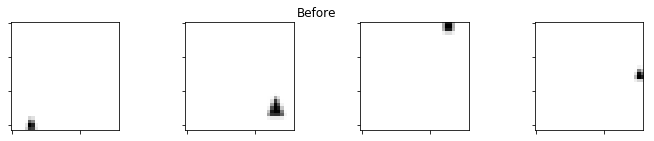

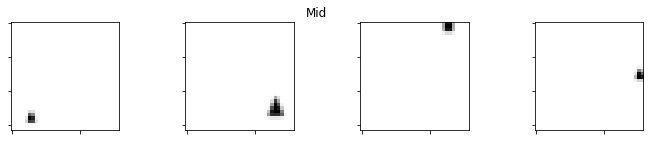

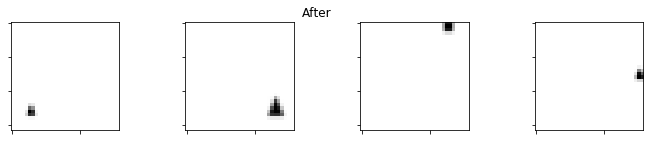

In [15]:
(test_before, test_after), test_mid = sample_train(4)
print("Before: {}".format(test_before.shape))
print("After:  {}".format(test_after.shape))
print("Mid:    {}".format(test_mid.shape))
size = (12, 2)
plot_images(test_before, size, "Before")
plot_images(test_mid, size, "Mid")
plot_images(test_after, size, "After")

Before: (4, 32, 32)
After:  (4, 32, 32)
Mid:    (4, 32, 32)


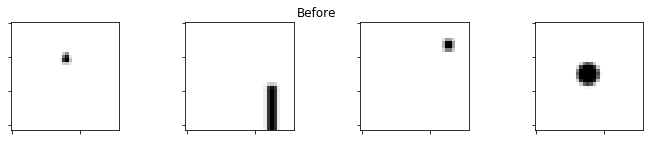

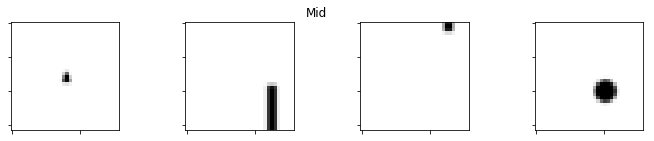

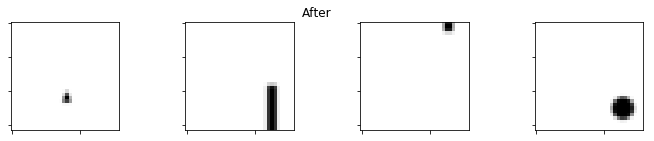

In [16]:
(test_before, test_after), test_mid = sample_dev(4, 11)
print("Before: {}".format(test_before.shape))
print("After:  {}".format(test_after.shape))
print("Mid:    {}".format(test_mid.shape))
plot_images(test_before, size, "Before")
plot_images(test_mid, size, "Mid")
plot_images(test_after, size, "After")

In [17]:
def content_loss(x, gd):
    x, gd = tf.contrib.layers.flatten(x), tf.contrib.layers.flatten(gd)
    return tf.norm(x-gd)


def gan_loss(logits_real, logits_fake):
    G_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_fake), logits = logits_fake)
    
    D_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_real), logits = logits_real)\
     +  tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logits_fake), logits = logits_fake)
        
    G_loss = tf.reduce_mean(G_loss)
    D_loss = tf.reduce_mean(D_loss)
    return D_loss, G_loss

In [19]:
def generate(x1, x2,  is_training=True):
    """
    Input:
        x1, x2: batch size of images for inference
    Output:
        predicted images of batch size
    """
    with tf.variable_scope("generator"):
        # reshape and concatenate
        x1 = tf.reshape(x1, [-1,  32, 32, 1])
        x2 = tf.reshape(x2, [-1,  32, 32, 1])
        x = tf.concat([(x1+x2)/2, (x2-x1)/2], axis=3)
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, 1024, activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, training=is_training)
        
        x = tf.layers.dense(x, 8*8*128, activation=tf.nn.relu)
        x = tf.reshape(x, [-1, 8, 8, 128])
        
        x = tf.layers.conv2d(x, filters = 64, kernel_size=2, padding='same', activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, axis=3, training=is_training)

        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.relu, padding='same')
        x = tf.layers.batch_normalization(x,  axis=3, training=is_training)
        
        img = tf.layers.conv2d_transpose(x, filters=1, kernel_size=(4, 4),  strides=(2, 2), activation=tf.nn.tanh, padding='same')
        img = tf.reshape(img, [-1, 32, 32, 1])
        return img

In [20]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    return D_solver, G_solver

In [21]:
def get_generattion(before, after, mid):
    dic = {batch_before: before, batch_after: after, batch_mid: mid, is_training: False}
    gen_batch = sess.run(G_batch, dic)
    gen_batch, loss = sess.run([G_batch, G_loss], dic)
    return gen_batch, loss

### Model Param

In [22]:
gap = 3
batch_size = 128

learning_rate = 1e-4
beta = 0.9
num_iteration = 3000
noise_dim = 128
relu_alpha = 0.01

In [23]:
tf.reset_default_graph()
batch_mid        = tf.placeholder(tf.float32, [None, 32, 32])
batch_before     = tf.placeholder(tf.float32, [None, 32, 32])
batch_after      = tf.placeholder(tf.float32, [None, 32, 32])
is_training      = tf.placeholder(tf.bool, ())

G_batch = generate(batch_before, batch_after)

G_loss = content_loss(G_batch, batch_mid)
_, G_solver = get_solvers(learning_rate, beta)

G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

In [24]:
def train(sess, G_step, G_loss, batch_size, num_iteration, plot_every = 400, show_loss_every=400, nPlot=6):
    g_losses = []
    for i in range(num_iteration):
        (real_before, real_after), real_mid = sample_train(batch_size, gap)
        dic = {batch_mid: real_mid, batch_before: real_before, batch_after: real_after, is_training: True}
        _, G_loss_curr = sess.run([G_train_step, G_loss], dic)
        
        g_losses.append(G_loss_curr)
        if i%show_loss_every ==0:
            print("Iteration {}:  G_loss = {}".format(i, G_loss_curr))
            
        if i%plot_every == 0:
            gen_batch_test = sess.run(G_batch, feed_dict=\
                                      {batch_before: real_before, batch_after: real_after, is_training: False})
            plot_batch_images(gen_batch_test[:nPlot], (16, 2) , "Iteration: {}".format(i))
    return g_losses

Iteration 0:  G_loss = 395.2498474121094


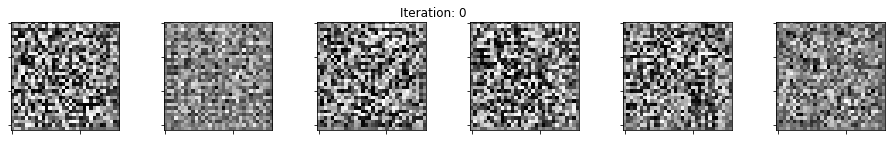

Iteration 400:  G_loss = 69.42530822753906


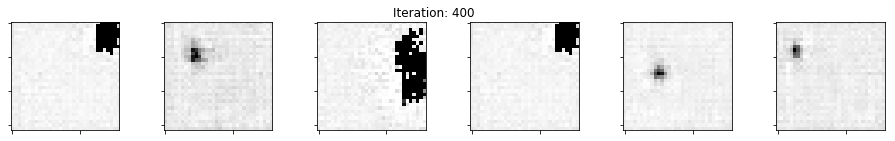

Iteration 800:  G_loss = 26.564979553222656


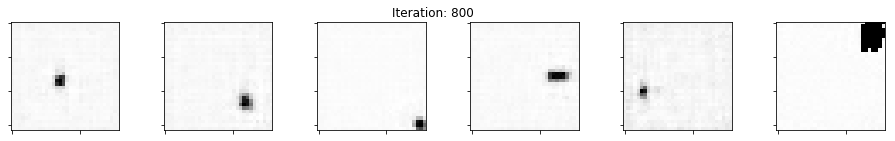

Iteration 1200:  G_loss = 10.673042297363281


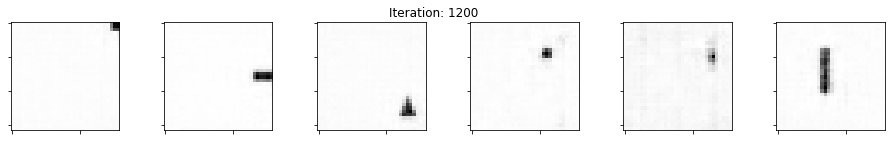

Iteration 1600:  G_loss = 4.705317497253418


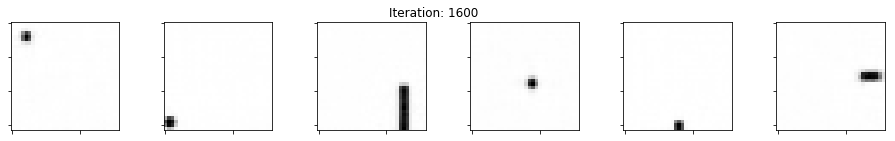

Iteration 2000:  G_loss = 4.1136274337768555


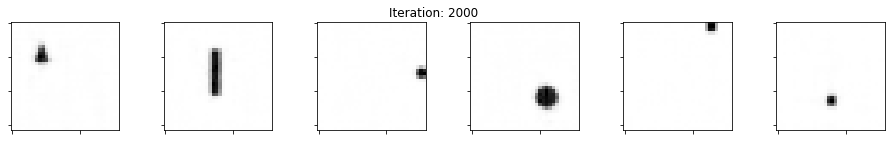

Iteration 2400:  G_loss = 3.489957332611084


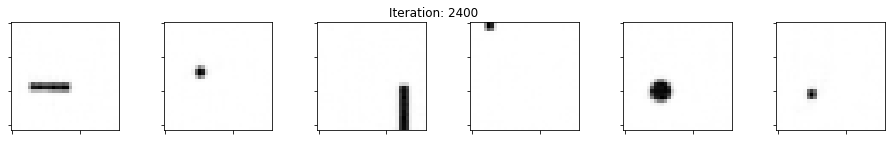

Iteration 2800:  G_loss = 2.9211487770080566


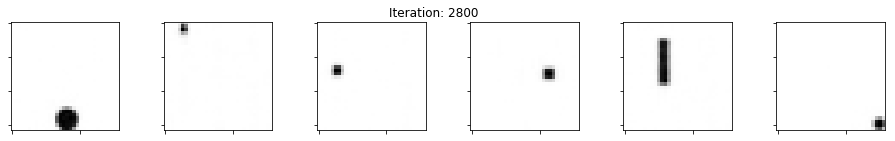

In [25]:
sess = get_session()
sess.run(tf.global_variables_initializer())
g_loss = train(sess, G_train_step, G_loss, batch_size, num_iteration)

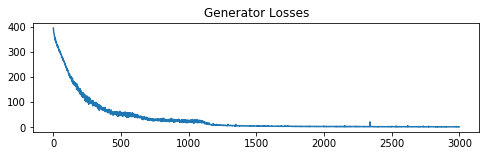

In [26]:
figsize = (8, 2)

plt.figure(figsize=figsize)
plt.plot(g_loss)
plt.title("Generator Losses")
plt.show()

In [27]:
def test_seen(num=4, gap = 3):
    (real_before, real_after), real_mid = sample_train(num, gap)
    gen_batch, loss = get_generattion(real_before, real_after, real_mid)
    print("Loss = {}".format(loss))
    size = (16, 2)
    plot_images(real_before, size, "Before")
    plot_images(real_after, size, "After")
    plot_images(real_mid, size, "Mid - Real")
    plot_images(gen_batch, size, "Mid - Generated")

Loss = 3.922271728515625


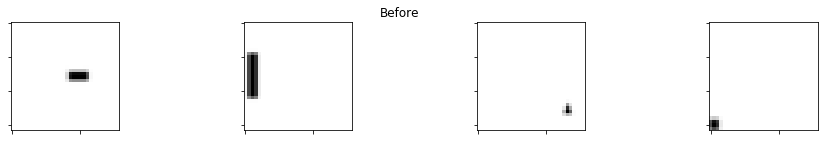

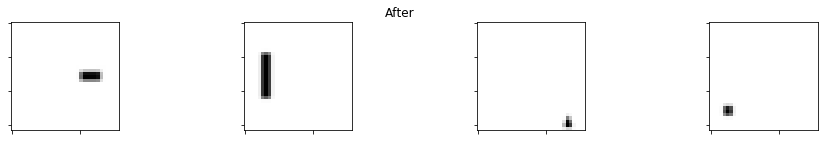

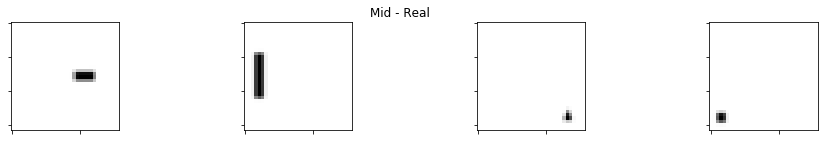

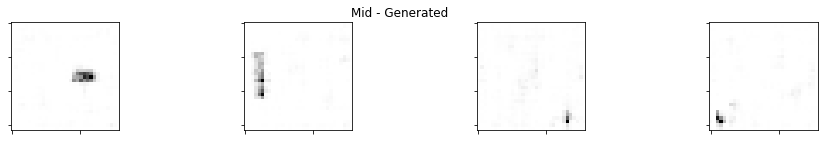

In [28]:
test_seen()

In [29]:
def test_unseens(num = 4, gap = 3):
    """
    randomely sample and test generator
    """
    (real_before, real_after), real_mid = sample_dev(num, gap)
    dic = {batch_before: real_before, batch_after: real_after, batch_mid: real_mid, is_training: False}
    gen_batch, loss = sess.run([G_batch, G_loss], dic)
    print("Loss = {}".format(loss))
    size = (16, 2)
    plot_images(real_before, size, "Before")
    plot_images(real_after, size, "After")
    plot_images(real_mid, size, "Mid - Real")
    plot_images(gen_batch, size, "Mid - Generated")

Loss = 3.5979559421539307


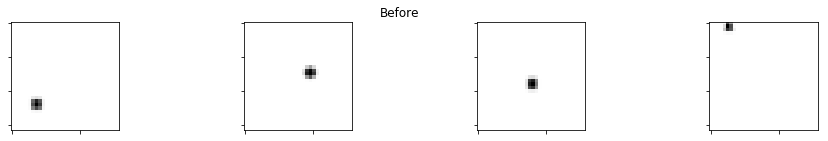

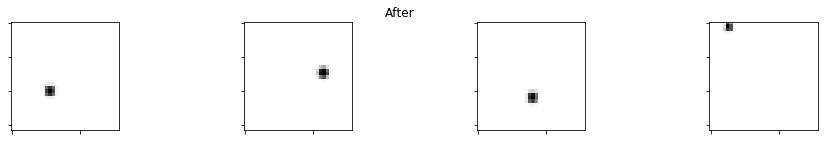

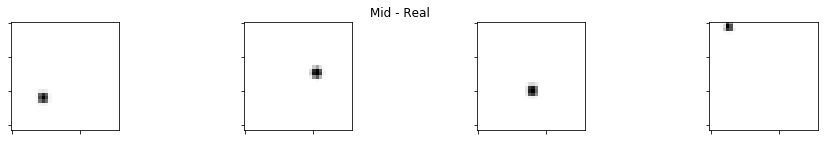

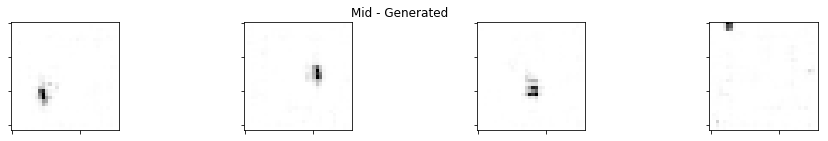

In [30]:
test_unseens()

## Test a total difference dataset

In [31]:
def sample_imgs(imgs, gap = 3, batch_size = 8):
    """
    return: (before, after), mid
    """
    before_indexes = np.random.choice(range(len(imgs) - gap - 1), batch_size, replace=False)
    before_indexes.sort()
    after_indexes = before_indexes + gap + 1
    mid_indexes = (before_indexes + after_indexes)//2
    return (imgs[before_indexes], imgs[after_indexes]), imgs[mid_indexes]

In [32]:
test_imgs = load_imgs("data/moving-box/test/rectangle-32x32.npz")

{'dim': (56, 32, 32), 'images:': 'rectangle'}


Loss = 6.075559139251709


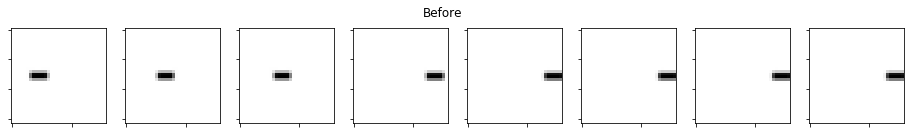

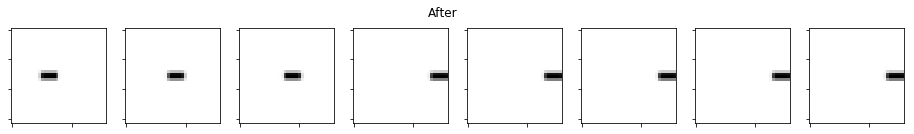

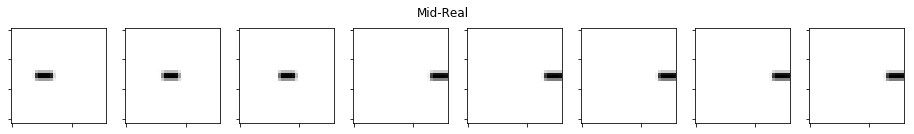

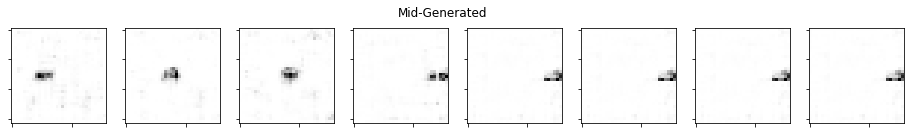

In [33]:
(test_before, test_after), test_mid = sample_imgs(test_imgs)
gen_batch, loss = get_generattion(test_before, test_after, test_mid)
print("Loss = {}".format(loss))
size = (16, 2)
plot_images(test_before, size, "Before")
plot_images(test_after, size, "After")
plot_images(test_mid, size, "Mid-Real")
plot_images(gen_batch, size, "Mid-Generated")